=== Table 3. Seasonal summary (Dataset 1: behavioural) ===


,n,risk_rate,reward_rate,hesitation_mean,hesitation_median,immediate_rat_presence_rate
season_label,,,,,,
Spring,756,0.481,0.567,12.846,4.0,0.091
Winter,151,0.563,0.364,6.040,2.0,0.152



=== Table 4. Seasonal summary (Dataset 2: contextual counts) ===


,rat_arrival_number,rat_minutes,bat_landing_number,food_availability,hours_after_sunset
season_label,,,,,
Spring,0.596,3.105,28.658,2.529,5.031
Winter,0.239,0.469,36.758,2.343,5.566



=== Seasonal tests (Winter vs Spring) ===
Hesitation (Mann–Whitney): U=46006.5, p=1.577e-04 | Winter mean=6.04s, Spring mean=12.85s
Risk × Season (χ²): χ²=3.02, df=1, p=8.219e-02


risk,0,1
season_label,,
Spring,392,364
Winter,66,85


Reward × Season (χ²): χ²=20.08, df=1, p=7.436e-06


reward,0,1
season_label,,
Spring,327,429
Winter,96,55


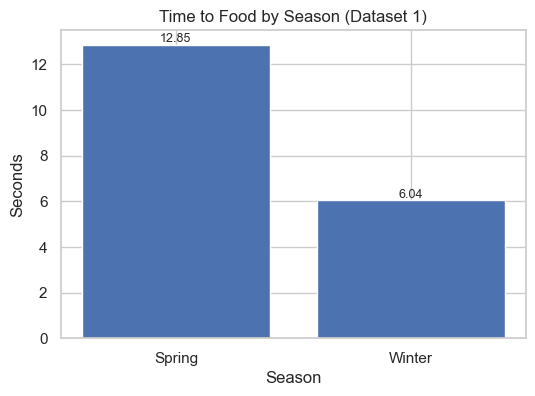

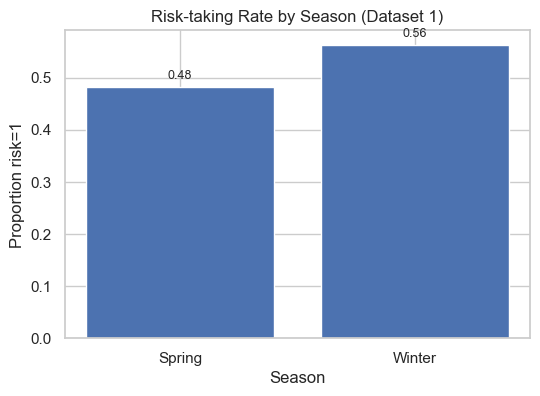

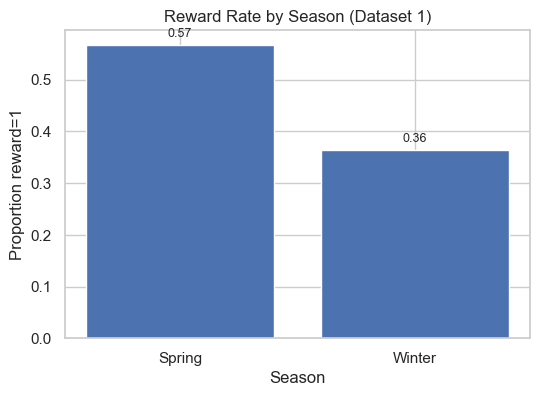

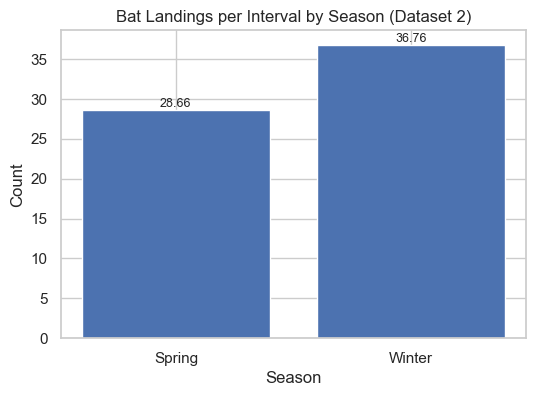

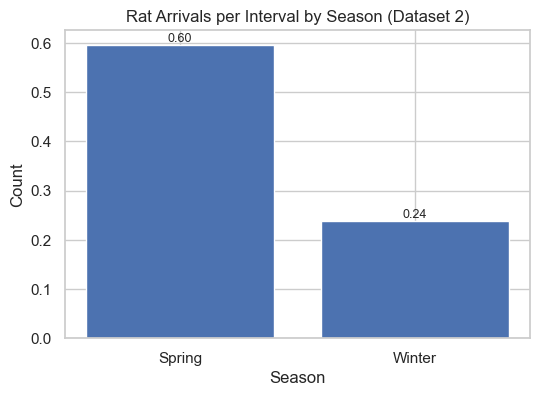

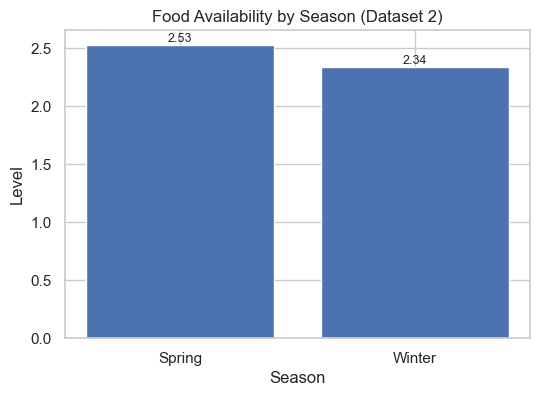

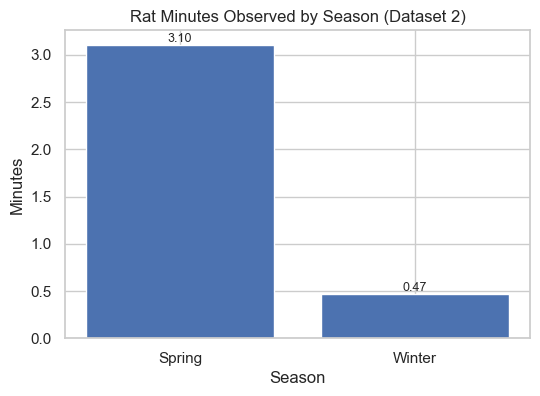

In [2]:
# --- HIT140 Assessment 3: Investigation B ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency

# Styling (inline only)
sns.set(style="whitegrid")

# 1) Load data (paths as per your Colab runtime)
df1 = pd.read_csv('dataset1.csv')
df2 = pd.read_csv('dataset2.csv')

# 2) Minimal cleaning & helpers
df1.columns = df1.columns.str.strip().str.lower().str.replace(" ", "_")
df2.columns = df2.columns.str.strip().str.lower().str.replace(" ", "_")

for col in ['bat_landing_to_food','risk','reward','hours_after_sunset','seconds_after_rat_arrival']:
    if col in df1.columns:
        df1[col] = pd.to_numeric(df1[col], errors='coerce')

for col in ['bat_landing_number','rat_arrival_number','rat_minutes','food_availability','hours_after_sunset','month']:
    if col in df2.columns:
        df2[col] = pd.to_numeric(df2[col], errors='coerce')

# Immediate rat presence flag (optional metric)
if 'seconds_after_rat_arrival' in df1.columns:
    df1['immediate_rat_presence'] = df1['seconds_after_rat_arrival'].abs() <= 30

# Season mapping
season_map = {0: 'Winter', 1: 'Spring'}
if 'season' in df1.columns:
    df1['season_label'] = df1['season'].map(season_map)

# If df2 has no season, derive from df1’s (month → most common season in df1)
if 'season' in df2.columns:
    df2['season_label'] = df2['season'].map(season_map)
else:
    if {'month','season_label'}.issubset(df1.columns):
        month_to_season = (df1.dropna(subset=['month','season_label'])
                             .groupby('month')['season_label']
                             .agg(lambda s: s.mode().iloc[0] if not s.empty else np.nan))
        df2['season_label'] = df2['month'].map(month_to_season)

# Keep Winter/Spring only (as per brief)
df1 = df1[df1['season_label'].isin(['Winter','Spring'])]
df2 = df2[df2['season_label'].isin(['Winter','Spring'])]

# ---------- SUMMARY TABLES (printed inline) ----------
print("=== Table 3. Seasonal summary (Dataset 1: behavioural) ===")
tbl3 = (df1.groupby('season_label')
          .agg(n=('season_label','size'),
               risk_rate=('risk','mean'),
               reward_rate=('reward','mean'),
               hesitation_mean=('bat_landing_to_food','mean'),
               hesitation_median=('bat_landing_to_food','median'),
               immediate_rat_presence_rate=('immediate_rat_presence','mean'))
          .round(3))
display(tbl3)

print("\n=== Table 4. Seasonal summary (Dataset 2: contextual counts) ===")
have = [c for c in ['rat_arrival_number','rat_minutes','bat_landing_number','food_availability','hours_after_sunset']
        if c in df2.columns]
tbl4 = df2.groupby('season_label')[have].mean().round(3)
display(tbl4)

# ---------- INFERENTIAL TESTS (printed inline) ----------
print("\n=== Seasonal tests (Winter vs Spring) ===")

# Hesitation time
if 'bat_landing_to_food' in df1.columns:
    w = df1.loc[df1['season_label']=='Winter', 'bat_landing_to_food'].dropna()
    s = df1.loc[df1['season_label']=='Spring', 'bat_landing_to_food'].dropna()
    if len(w) > 0 and len(s) > 0:
        u, p = mannwhitneyu(w, s, alternative='two-sided')
        print(f"Hesitation (Mann–Whitney): U={u:.1f}, p={p:.3e} | "
              f"Winter mean={w.mean():.2f}s, Spring mean={s.mean():.2f}s")

# Risk rate chi-square
ct_risk = pd.crosstab(df1['season_label'], df1['risk'])
if ct_risk.shape == (2,2):
    chi2, p, dof, _ = chi2_contingency(ct_risk)
    print(f"Risk × Season (χ²): χ²={chi2:.2f}, df={dof}, p={p:.3e}")
    display(ct_risk)

# Reward rate chi-square
ct_reward = pd.crosstab(df1['season_label'], df1['reward'])
if ct_reward.shape == (2,2):
    chi2, p, dof, _ = chi2_contingency(ct_reward)
    print(f"Reward × Season (χ²): χ²={chi2:.2f}, df={dof}, p={p:.3e}")
    display(ct_reward)

# ---------- INLINE PLOTS (NO FILES SAVED) ----------
def bar_prop(df, col, title, ylabel):
    prop = df.groupby('season_label')[col].mean()
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(prop.index, prop.values)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Season")
    for i, v in enumerate(prop.values):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
    plt.show()

def bar_mean(df, col, title, ylabel):
    means = df.groupby('season_label')[col].mean()
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(means.index, means.values)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Season")
    for i, v in enumerate(means.values):
        ax.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
    plt.show()

# Figure 1. Hesitation (time to food) by season (Dataset 1)
if 'bat_landing_to_food' in df1.columns:
    bar_mean(df1, 'bat_landing_to_food',
             "Time to Food by Season (Dataset 1)", "Seconds")

# Figure 2. Risk-taking rate by season (Dataset 1)
if 'risk' in df1.columns:
    bar_prop(df1, 'risk',
             "Risk-taking Rate by Season (Dataset 1)", "Proportion risk=1")

# Figure 3. Reward rate by season (Dataset 1)
if 'reward' in df1.columns:
    bar_prop(df1, 'reward',
             "Reward Rate by Season (Dataset 1)", "Proportion reward=1")

# Figure 4–7. Dataset 2 counts by season
for col, title, ylab in [
    ('bat_landing_number', "Bat Landings per Interval by Season (Dataset 2)", "Count"),
    ('rat_arrival_number', "Rat Arrivals per Interval by Season (Dataset 2)", "Count"),
    ('food_availability', "Food Availability by Season (Dataset 2)", "Level"),
    ('rat_minutes',       "Rat Minutes Observed by Season (Dataset 2)", "Minutes"),
]:
    if col in df2.columns:
        bar_mean(df2, col, title, ylab)


=== Effect sizes with 95% bootstrap CIs ===
Risk proportion Winter=0.563 (95% CI 0.483–0.642); Spring=0.481 (95% CI 0.447–0.519); Diff (S−W)=-0.081; Cohen's h=-0.163
Hesitation mean Winter=6.04s (95% CI 4.23–8.58); Spring=12.85s (95% CI 10.87–14.94); Mann–Whitney U=46006.5, p=1.577e-04, rank-biserial r=0.194

=== Quantile regression for Time-to-food (τ=0.25,0.50,0.75) ===

τ = 0.25


<class 'statsmodels.iolib.summary.Summary'>
"""
                          QuantReg Regression Results                          
===============================================================================
Dep. Variable:     bat_landing_to_food   Pseudo R-squared:           -1.199e-08
Model:                        QuantReg   Bandwidth:                       3.483
Method:                  Least Squares   Sparsity:                        10.32
Date:                 Thu, 16 Oct 2025   No. Observations:                  907
Time:                         00:10:55   Df Residuals:                      903
                                         Df Model:                            3
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0000      0.567      1.764      0.078      -0.113       2.113
season              3.145e-06      0.429   7.33e-06      1.000      -0.842       0.842
hours_after_sunset  2.855e-08      0.069   4.16e-07      1.000      -0.135       0.135
reward             -2.839e-06      0.307  -9.24e-06      1.000      -0.603       0.603
======================================================================================
"""


τ = 0.50


<class 'statsmodels.iolib.summary.Summary'>
"""
                          QuantReg Regression Results                          
===============================================================================
Dep. Variable:     bat_landing_to_food   Pseudo R-squared:             0.008021
Model:                        QuantReg   Bandwidth:                       3.796
Method:                  Least Squares   Sparsity:                        13.42
Date:                 Thu, 16 Oct 2025   No. Observations:                  907
Time:                         00:10:57   Df Residuals:                      903
                                         Df Model:                            3
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.0000      0.762      3.937      0.000       1.505       4.495
season                 2.0000      0.605      3.305      0.001       0.812       3.188
hours_after_sunset  2.049e-07      0.092   2.22e-06      1.000      -0.181       0.181
reward                -1.0000      0.452     -2.210      0.027      -1.888      -0.112
======================================================================================
"""


τ = 0.75


<class 'statsmodels.iolib.summary.Summary'>
"""
                          QuantReg Regression Results                          
===============================================================================
Dep. Variable:     bat_landing_to_food   Pseudo R-squared:              0.01679
Model:                        QuantReg   Bandwidth:                       3.553
Method:                  Least Squares   Sparsity:                        50.49
Date:                 Thu, 16 Oct 2025   No. Observations:                  907
Time:                         00:10:58   Df Residuals:                      903
                                         Df Model:                            3
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.6261      2.418      3.567      0.000       3.880      13.372
season                 7.0339      1.991      3.533      0.000       3.127      10.941
hours_after_sunset    -0.2096      0.295     -0.710      0.478      -0.789       0.370
reward                -2.6417      1.491     -1.772      0.077      -5.568       0.285
======================================================================================
"""

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


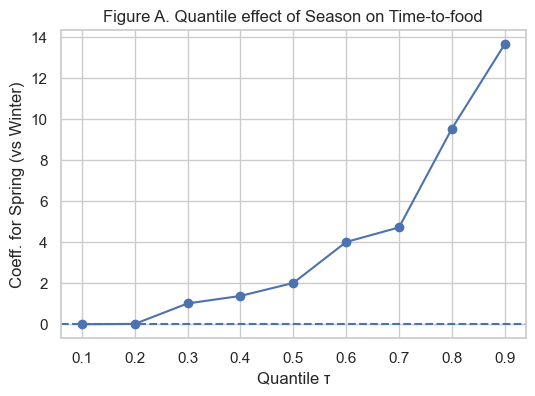


=== Seasonal patterns by time-of-night bins ===

Table: Risk proportion by time-of-night × season


C:\Users\sandh\AppData\Local\Temp\ipykernel_22216\624761220.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['night_bin','season_label'])['risk']


season_label,Spring,Winter
night_bin,,
≤2h,0.527,0.500
2–4h,0.497,0.629
4–6h,0.530,0.676
6–8h,0.427,0.361
>8h,0.453,0.625


C:\Users\sandh\AppData\Local\Temp\ipykernel_22216\624761220.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['night_bin','season_label'])['bat_landing_to_food']


Table: Median hesitation (s) by time-of-night × season


season_label,Spring,Winter
night_bin,,
≤2h,2.0,3.5
2–4h,5.0,2.0
4–6h,5.0,2.0
6–8h,4.0,2.0
>8h,4.0,2.5


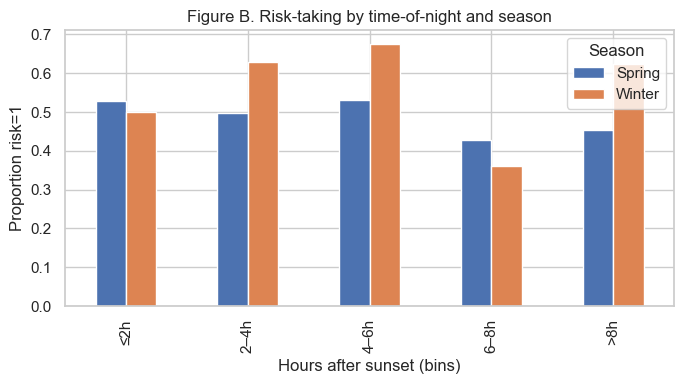


=== Partial Spearman (residualized) for Dataset 2 ===
Partial Spearman (controlling for hours_after_sunset): ρ=-0.120, p=0.0000

=== Interaction visual (means) ===


C:\Users\sandh\AppData\Local\Temp\ipykernel_22216\624761220.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df2.groupby(['season_label','rat_bin'])['bat_landing_number'].mean().reset_index()


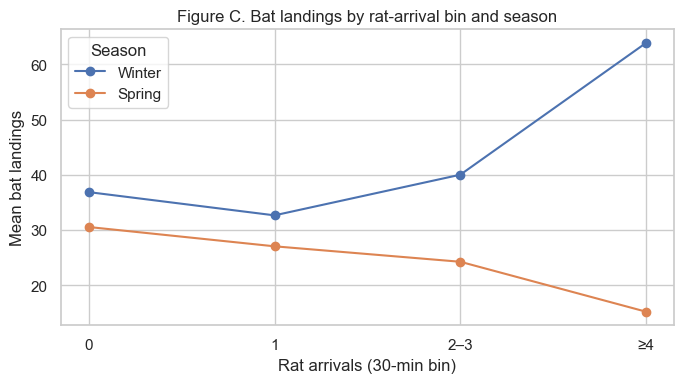

In [3]:
# --- HIT140 Assessment 3: Investigation B (Further Analysis) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set(style="whitegrid")

# --- Assumes df1 and df2 from your previous cells (already cleaned & have 'season_label') ---
assert {'Winter','Spring'}.issubset(set(df1['season_label'].dropna().unique())), "df1['season_label'] missing"
assert {'Winter','Spring'}.issubset(set(df2['season_label'].dropna().unique())), "df2['season_label'] missing"

# Helper: bootstrap CI for a scalar statistic
def bootstrap_ci(x, stat_func=np.mean, nboot=5000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    x = np.asarray(pd.Series(x).dropna().values)
    boots = [stat_func(rng.choice(x, size=x.size, replace=True)) for _ in range(nboot)]
    lo, hi = np.quantile(boots, [alpha/2, 1-alpha/2])
    return stat_func(x), (lo, hi)

# 1) EFFECT SIZES + BOOTSTRAPPED CONFIDENCE INTERVALS

print("=== Effect sizes with 95% bootstrap CIs ===")

# 1a) Risk-taking proportion Winter vs Spring
risk_w = df1.loc[df1['season_label']=='Winter', 'risk'].dropna().astype(int)
risk_s = df1.loc[df1['season_label']=='Spring', 'risk'].dropna().astype(int)
p_w, ci_w = bootstrap_ci(risk_w, stat_func=np.mean)
p_s, ci_s = bootstrap_ci(risk_s, stat_func=np.mean)
risk_diff = p_s - p_w

# Cohen's h for proportions
def cohens_h(p1, p2):
    return 2*np.arcsin(np.sqrt(p2)) - 2*np.arcsin(np.sqrt(p1))
h = cohens_h(p_w, p_s)

print(f"Risk proportion Winter={p_w:.3f} (95% CI {ci_w[0]:.3f}–{ci_w[1]:.3f}); "
      f"Spring={p_s:.3f} (95% CI {ci_s[0]:.3f}–{ci_s[1]:.3f}); "
      f"Diff (S−W)={risk_diff:.3f}; Cohen's h={h:.3f}")

# 1b) Hesitation (bat_landing_to_food) Winter vs Spring
hes_w = df1.loc[df1['season_label']=='Winter', 'bat_landing_to_food']
hes_s = df1.loc[df1['season_label']=='Spring', 'bat_landing_to_food']
m_w, ci_mw = bootstrap_ci(hes_w)
m_s, ci_ms = bootstrap_ci(hes_s)

# Mann–Whitney effect size: rank-biserial correlation r_rb = 1 - 2*U/(n1*n2)
U, p = stats.mannwhitneyu(hes_w, hes_s, alternative='two-sided')
n1, n2 = len(hes_w), len(hes_s)
r_rb = 1 - 2*U/(n1*n2)

print(f"Hesitation mean Winter={m_w:.2f}s (95% CI {ci_mw[0]:.2f}–{ci_mw[1]:.2f}); "
      f"Spring={m_s:.2f}s (95% CI {ci_ms[0]:.2f}–{ci_ms[1]:.2f}); "
      f"Mann–Whitney U={U:.1f}, p={p:.3e}, rank-biserial r={r_rb:.3f}")

# 2) QUANTILE REGRESSION (25th, 50th, 75th) for hesitation

print("\n=== Quantile regression for Time-to-food (τ=0.25,0.50,0.75) ===")
qr_df = df1[['bat_landing_to_food','season_label','hours_after_sunset','reward']].dropna().copy()
qr_df['season'] = (qr_df['season_label']=='Spring').astype(int)  # Spring=1, Winter=0
for q in [0.25, 0.50, 0.75]:
    qr = smf.quantreg('bat_landing_to_food ~ season + hours_after_sunset + reward', data=qr_df).fit(q=q)
    print(f"\nτ = {q:.2f}")
    display(qr.summary())

# Visual: coefficients over quantiles (season only)
taus = np.linspace(0.1, 0.9, 9)
betas = []
for q in taus:
    m = smf.quantreg('bat_landing_to_food ~ season + hours_after_sunset + reward', data=qr_df).fit(q=q)
    betas.append(m.params['season'])
plt.figure(figsize=(6,4))
plt.plot(taus, betas, marker='o')
plt.xlabel('Quantile τ')
plt.ylabel('Coeff. for Spring (vs Winter)')
plt.title('Figure A. Quantile effect of Season on Time-to-food')
plt.axhline(0, ls='--')
plt.show()


# 3) TIME-OF-NIGHT STRATIFICATION

print("\n=== Seasonal patterns by time-of-night bins ===")
bins = [-np.inf, 2, 4, 6, 8, np.inf]
labels = ['≤2h','2–4h','4–6h','6–8h','>8h']
df1['night_bin'] = pd.cut(df1['hours_after_sunset'], bins=bins, labels=labels)

# Risk rate by season × night bin
pivot_risk = (df1.dropna(subset=['night_bin'])
                .groupby(['night_bin','season_label'])['risk']
                .mean().unstack())
print("\nTable: Risk proportion by time-of-night × season")
display(pivot_risk.round(3))

pivot_hes = (df1.dropna(subset=['night_bin'])
               .groupby(['night_bin','season_label'])['bat_landing_to_food']
               .median().unstack())
print("Table: Median hesitation (s) by time-of-night × season")
display(pivot_hes.round(2))

# Plot risk by bins
pivot_risk.plot(kind='bar', figsize=(7,4))
plt.title('Figure B. Risk-taking by time-of-night and season')
plt.ylabel('Proportion risk=1'); plt.xlabel('Hours after sunset (bins)')
plt.legend(title='Season')
plt.tight_layout(); plt.show()


# 4) PARTIAL SPEARMAN: BAT LANDINGS ~ RAT ARRIVALS | HOURS_AFTER_SUNSET

print("\n=== Partial Spearman (residualized) for Dataset 2 ===")
d2 = df2[['bat_landing_number','rat_arrival_number','hours_after_sunset']].dropna().copy()

# Residualize both counts w.r.t hours_after_sunset via linear regression (rank-based alt. would be similar)
for col in ['bat_landing_number','rat_arrival_number']:
    X = sm.add_constant(d2['hours_after_sunset'])
    res = sm.OLS(d2[col], X).fit().resid
    d2[f'{col}_resid'] = res

rho, pval = stats.spearmanr(d2['bat_landing_number_resid'], d2['rat_arrival_number_resid'])
print(f"Partial Spearman (controlling for hours_after_sunset): ρ={rho:.3f}, p={pval:.4f}")


# 5) INTERACTION PLOT (SEASON × RAT ARRIVALS → BAT LANDINGS)

print("\n=== Interaction visual (means) ===")
df2['rat_bin'] = pd.cut(df2['rat_arrival_number'],
                        bins=[-0.5, 0.5, 1.5, 3.5, np.inf],
                        labels=['0','1','2–3','≥4'])
means = df2.groupby(['season_label','rat_bin'])['bat_landing_number'].mean().reset_index()

plt.figure(figsize=(7,4))
for s in ['Winter','Spring']:
    sub = means[means['season_label']==s]
    plt.plot(sub['rat_bin'], sub['bat_landing_number'], marker='o', label=s)
plt.title('Figure C. Bat landings by rat-arrival bin and season')
plt.xlabel('Rat arrivals (30-min bin)'); plt.ylabel('Mean bat landings')
plt.legend(title='Season'); plt.tight_layout(); plt.show()